# Demo RNA Multi-Perceptrón Backpropagation usando clases de Keras para identificar TIPOS de Flores IRIS
Adaptado de https://www.tensorflow.org/tutorials/estimator/premade

1) Cargar librerías:

In [1]:
#@title Librerías a usar
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

Librerías cargadas


2) Cargar los datos:

In [2]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demo IRIS'  #@param {type:"string"}


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
## selección de los parámetros 

#@markdown ### Archivo de datos a utilizar:
archivo_datos = '/datos/IRIS.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo clase / objetivo:
atributo_clase = 'Clase' #@param {type:"string"}
#@markdown ### Descripción de los valores del atributo clase / objetivo:  (nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, agregar "na")
nombre_clases = 'na, Setosa, Versicolor, Virginica' #@param {type:"string"}
#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   70#@param {type:"integer"}

## aplicación de los parámetros elegidos

# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_clase

# define valores de clases para ejemplo IRIS
CLASES = [ ]
for val in nombre_clases.split(','):
  CLASES.append( val )

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

print("Configuración definida de ", archivo_datos)
print("Atributo clase: ", ClassAttributeName, ": ", CLASES)

Configuración definida de  /datos/IRIS.csv
Atributo clase:  Clase :  ['na', ' Setosa', ' Versicolor', ' Virginica']


In [4]:
#@title Cargar datos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())

# genera los datos solo con la clase para entrenar y probar
Y = np.array(df.pop(ClassAttributeName))
X = np.array(df)


> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max       7.900000     4.400000     6.9

In [5]:
#@title Normalizar datos de entrada (opcional)

print("10 primeros datos de Entrada antes de normalizar: ")
print(X[:10])

from sklearn import preprocessing

# elegir el método de normalización
scaler = preprocessing.MinMaxScaler()
#scaler = preprocessing.MaxAbsScaler()

# normaliza los datos de entrada
X = scaler.fit_transform(X)

print("\n\n10 primeros datos de Entrada después de normalizar: ")
print(X[:10])

10 primeros datos de Entrada antes de normalizar: 
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]


10 primeros datos de Entrada después de normalizar: 
[[0.22222222 0.625      0.06779661 0.04166667]
 [0.16666667 0.41666667 0.06779661 0.04166667]
 [0.11111111 0.5        0.05084746 0.04166667]
 [0.08333333 0.45833333 0.08474576 0.04166667]
 [0.19444444 0.66666667 0.06779661 0.04166667]
 [0.30555556 0.79166667 0.11864407 0.125     ]
 [0.08333333 0.58333333 0.06779661 0.08333333]
 [0.19444444 0.58333333 0.08474576 0.04166667]
 [0.02777778 0.375      0.06779661 0.04166667]
 [0.16666667 0.45833333 0.08474576 0.        ]]


In [6]:
#@title Preparar datos

# separa al azar usando muestreo estratificado con proporción indicada
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)

# genera salida codificada para softMax
y_trainEnc =  np_utils.to_categorical(y_train)
y_testEnc =  np_utils.to_categorical(y_test)

# muestra resultados
print("> Para Ambos: ")
print(" - dictMapeo: ", CLASES)

print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
for i in range(len(CLASES)):
  cant = 0
  for y in y_train:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
for i in range(len(CLASES)):
  cant = 0
  for y in y_test:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)


> Para Ambos: 
 - dictMapeo:  ['na', ' Setosa', ' Versicolor', ' Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (104, 4)
 - y_train (cant):  104
     na [ 0 ]: 0
      Setosa [ 1 ]: 35
      Versicolor [ 2 ]: 34
      Virginica [ 3 ]: 35

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (46, 4)
 - y_test (cant):  46
     na [ 0 ]: 0
      Setosa [ 1 ]: 15
      Versicolor [ 2 ]: 16
      Virginica [ 3 ]: 15


3) Establecer el modelo para la RNA

In [7]:
rna_cant_neuronas_capas_ocultas = '240, 60, 12' #@param {type:"string"}
rna_tipo_capa_salida = 'softmax-MultiClase' #@param ["lineal-Numero", "softmax-MultiClase"]
rna_cant_epocas_entrenamiento =  15#@param {type:"integer"}

# define tamaño de datos de entrada 
num_inputs = x_train.shape[1]

# cantidad de neuronas ocultas 
#hidden_layers = [ num_inputs*3//4, num_inputs//2 ] 
hidden_layers = []
for val in rna_cant_neuronas_capas_ocultas.split(','):
  hidden_layers.append( int(val) )

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
tipo_output_softMax = (rna_tipo_capa_salida[:7] == 'softmax')

# cantidad de épocas del entrenamiento
cantEpocas = (100 if rna_cant_epocas_entrenamiento<1 else rna_cant_epocas_entrenamiento)

print("Configuración de RNA MLP Backpropagation definida: [", num_inputs, hidden_layers, ("Softmax" if tipo_output_softMax else "Dense[1] ")," ] ")

Configuración de RNA MLP Backpropagation definida: [ 4 [240, 60, 12] Softmax  ] 


Modelo creado con  5  capas:
Model: "RNA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 4)]               0         
_________________________________________________________________
hidd_1 (Dense)               (None, 240)               1200      
_________________________________________________________________
hidd_2 (Dense)               (None, 60)                14460     
_________________________________________________________________
hidd_3 (Dense)               (None, 12)                732       
_________________________________________________________________
output (Dense)               (None, 4)                 52        
Total params: 16,444
Trainable params: 16,444
Non-trainable params: 0
_________________________________________________________________




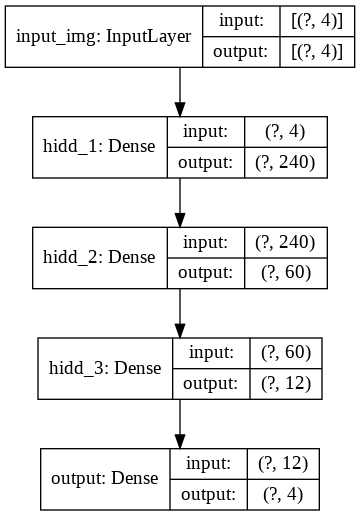

In [8]:
#@title Establecer modelo

# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente
input_img_Lay = Input(shape=(num_inputs,), name='input_img') # capa de entrada
eachLay = input_img_Lay
auxName = 'hidd_'
auxId = 1 
for num_hid in hidden_layers:  
    
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = Dense(num_hid, name=auxlayerName)(eachLay) # capas ocultas

# agrega capa de salida
if tipo_output_softMax:
    # se genera una capa softmax
    output_img_Lay = Dense(units = len(CLASES), activation='softmax', name='output')(eachLay) # capa de salida
else:
    # se genera una capa lineal con una salida numérica
    output_img_Lay = Dense(1, activation=None, name='output')(eachLay) # capa de salida

# genera el modelo RNA MLP Backpropagation
model = Model(input_img_Lay, output_img_Lay, name='RNA')
#model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
if tipo_output_softMax:
    # utiliza un loss de multiple clases
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # utiliza un loss de valor numérico
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


4) Entrenar el modelo de la RNA:

In [9]:
#@title Entrenar

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       (y_trainEnc if tipo_output_softMax else y_train), 
                                       test_size=0.1)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas, 
          validation_data=(x_v, y_v,) ) 

print("\n>Entrenamiento Finalizado.")


> De los  104 ejemplos de entrenamiento: 
            se usan  93 ejemplos para entrenar 
            y  11 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/15
3/3 [==============================] - 0s 52ms/step - loss: 1.3862 - accuracy: 0.1398 - val_loss: 1.2887 - val_accuracy: 0.1818
Epoch 2/15
3/3 [==============================] - 0s 6ms/step - loss: 1.2150 - accuracy: 0.5161 - val_loss: 1.1456 - val_accuracy: 0.5455
Epoch 3/15
3/3 [==============================] - 0s 7ms/step - loss: 1.0809 - accuracy: 0.7957 - val_loss: 0.9610 - val_accuracy: 0.9091
Epoch 4/15
3/3 [==============================] - 0s 6ms/step - loss: 0.9638 - accuracy: 0.8925 - val_loss: 0.8135 - val_accuracy: 1.0000
Epoch 5/15
3/3 [==============================] - 0s 7ms/step - loss: 0.8720 - accuracy: 0.6667 - val_loss: 0.6626 - val_accuracy: 1.0000
Epoch 6/15
3/3 [==============================] - 0s 7ms/step - loss: 0.7769 - accuracy: 0.6882 - val_loss: 0.6230 - val_accuracy: 1.0000
Epoch 7/1

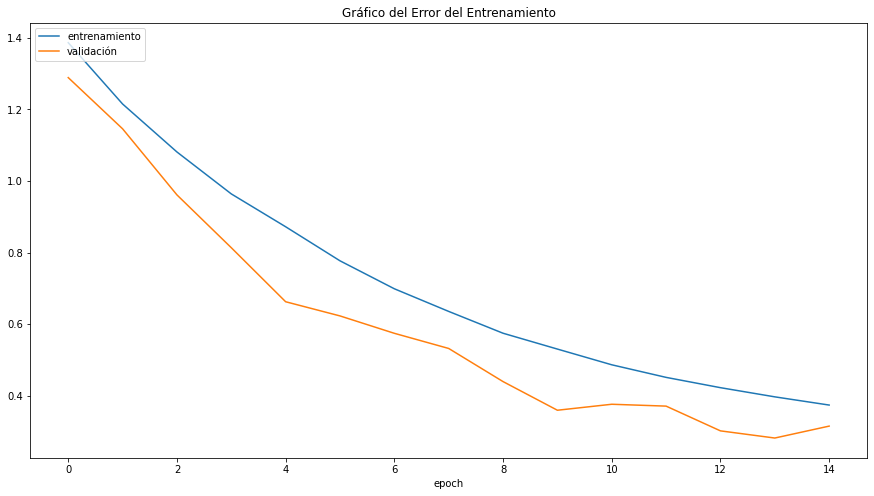

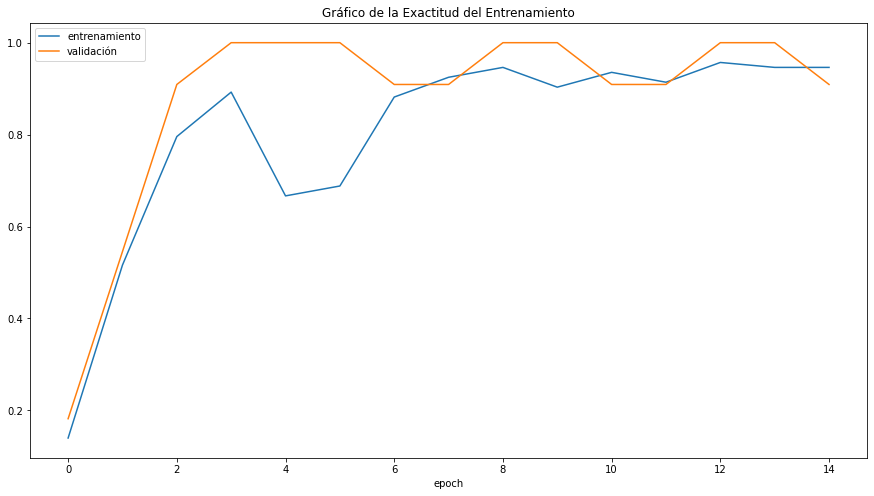

In [10]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8)) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

*** Resultados con datos de Entrenamiento: 
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Versicolor / RNA:  Versicolor (2): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Versicolor / RNA:  Versicolor (2): ok
Real:  Virginica / RNA:  Versicolor (2): error!
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Versicolor / RNA:  Versicolor (2): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Versicolor / RNA:  Versicolor (2): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Versicolor / RNA:  Versicolor (2): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Versicolor / RNA:  Versicolor (2): ok
Real:  Set

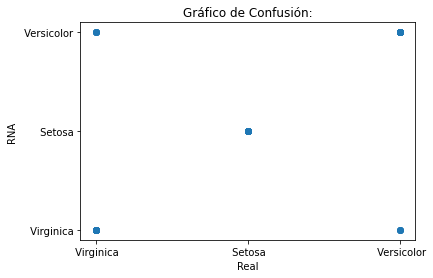

In [11]:
#@title Probar red entrenada con datos de entrenamiento
# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, clases_map):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ] 

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]       
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:      
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + clReal + ' / RNA: ' 
        strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'   
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    print(cmtx)
    print("\n")

    # gráfico de comparación
    plt.title('Gráfico de Confusión:')
    plt.xlabel('Real')
    plt.ylabel('RNA')
    plt.scatter(classReal, classPreds)

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, CLASES)


6) Evaluar el modelo de la RNA entrenado con los datos de prueba:

2/2 [==============================] - 0s 1ms/step - loss: 0.3671 - accuracy: 0.9783

>Evaluación del Modelo: 
    - Error:  0.36713218688964844
    - Exactitud:  97.826087474823




*** Resultados con datos de Prueba: 
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Versicolor / RNA:  Versicolor (2): ok
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Versicolor / RNA:  Versicolor (2): ok
Real:  Versicolor / RNA:  Versicolor (2): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Versicolor / RNA:  Versicolor (2): ok
Real:  Versicolor / RNA:  Versicolor (2): ok
Real:  Setosa / RNA:  Setosa (1): ok
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Virginica / RNA:  Virginica (3): ok
Real:  Versicolor / RNA:  Versicolor (2): ok
Real:  Setosa / RN

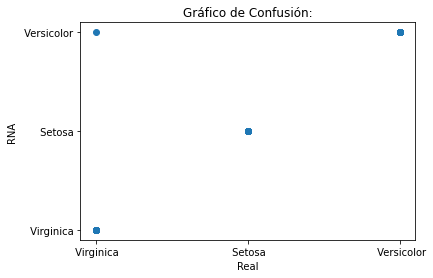

In [12]:
 #@title Probar red entrenada con datos de prueba
 # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, CLASES)